Splitting Datasets into Validtion and Train

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from shutil import copy2

# Define paths
fake_path = "C:\\Users\\yakup\\Desktop\\Special Dataset\\Frames\\Fake"
real_path = "C:\\Users\\yakup\\Desktop\\Special Dataset\\Frames\\Real"
total_test_path = "C:\\Users\\yakup\\Desktop\\Test\\Total"
train_path = "C:\\Users\\yakup\\Desktop\\Train"
val_path = "C:\\Users\\yakup\\Desktop\\Validation"

# Parameters
batch_size = 64
num_epochs = 20
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to split data into train and validation sets
def split_data(src_folder, train_folder, val_folder, val_size=0.2):
    if not os.path.exists(train_folder):
        os.makedirs(os.path.join(train_folder, "Fake"))
        os.makedirs(os.path.join(train_folder, "Real"))
    if not os.path.exists(val_folder):
        os.makedirs(os.path.join(val_folder, "Fake"))
        os.makedirs(os.path.join(val_folder, "Real"))
    
    for label in ["Fake", "Real"]:
        src_path = os.path.join(src_folder, label)
        images = os.listdir(src_path)
        train_imgs, val_imgs = train_test_split(images, test_size=val_size, random_state=42)

        for img in train_imgs:
            copy2(os.path.join(src_path, img), os.path.join(train_folder, label, img))
        for img in val_imgs:
            copy2(os.path.join(src_path, img), os.path.join(val_folder, label, img))

# Split images into train and validation sets
split_data("C:\\Users\\yakup\\Desktop\\Special Dataset\\Frames", train_path, val_path)
print("Data successfully split into training and validation sets.")

# Loading datasets
data_dir = train_path
dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

# Model setup
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

def evaluate(model, val_loader):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

labels, preds = evaluate(model, val_loader)
conf_matrix = confusion_matrix(labels, preds)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(labels, preds))

torch.save(model.state_dict(), "resnet18_seperated_dataset_deepfake_detector.pth")
print("Model saved as resnet18_seperated_dataset_deepfake_detector.pth")



Data successfully split into training and validation sets.


c:\Users\yakup\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yakup\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 0.2535
Epoch 2/20, Loss: 0.2359
Epoch 3/20, Loss: 0.2309
Epoch 4/20, Loss: 0.2286
Epoch 5/20, Loss: 0.2231
Epoch 6/20, Loss: 0.2171
Epoch 7/20, Loss: 0.2104
Epoch 8/20, Loss: 0.2020
Epoch 9/20, Loss: 0.1922
Epoch 10/20, Loss: 0.1804
Epoch 11/20, Loss: 0.1680
Epoch 12/20, Loss: 0.1552
Epoch 13/20, Loss: 0.1418
Epoch 14/20, Loss: 0.1298
Epoch 15/20, Loss: 0.1131
Epoch 16/20, Loss: 0.1013
Epoch 17/20, Loss: 0.0889
Epoch 18/20, Loss: 0.0869
Epoch 19/20, Loss: 0.0769
Epoch 20/20, Loss: 0.0660
Confusion Matrix:
[[2975  190]
 [ 324 2877]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3165
           1       0.94      0.90      0.92      3201

    accuracy                           0.92      6366
   macro avg       0.92      0.92      0.92      6366
weighted avg       0.92      0.92      0.92      6366

Model saved as resnet18_seperated_dataset_deepfake_detector.pth


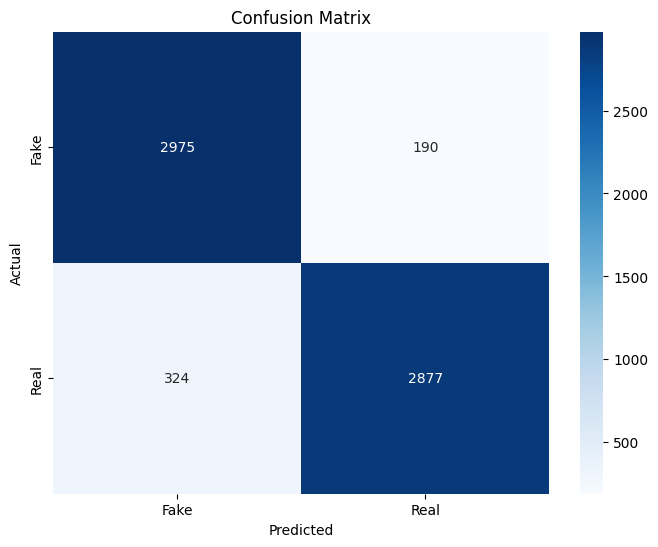

In [2]:
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

# Data from the confusion matrix
conf_matrix = np.array([[2975, 190],
                        [324, 2877]])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Test Dataset was created manually by extracting from the Frames folder. By an iteration all the images are checked and the results are given

In [3]:
import os
import torch
from torchvision import transforms, models
from PIL import Image

# Path to the test images and trained model
test_dir = r"C:\Users\yakup\Desktop\Test\Total"
model_path = "resnet18_seperated_dataset_deepfake_detector.pth"

model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Define image preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to predict the label of an image
def predict_image(image_path, model):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    return "Real" if preds.item() == 1 else "Fake"

# Iterate through all images in the test directory
results = []
for image_name in os.listdir(test_dir):
    image_path = os.path.join(test_dir, image_name)
    if os.path.isfile(image_path):
        prediction = predict_image(image_path, model)
        results.append((image_name, prediction))

for image_name, prediction in results:
    print(f"{image_name}: {prediction}")

output_file = "test_image_predictions.txt"
with open(output_file, "w") as f:
    for image_name, prediction in results:
        f.write(f"{image_name}: {prediction}\n")
print(f"Results saved to {output_file}")

c:\Users\yakup\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yakup\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\yakup\AppData\Local\Temp\ipykernel_3232\1580497798.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future 

27_26__kitchen_pan__IE9N0ZI9_frame_360.jpg: Fake
27_26__kitchen_pan__IE9N0ZI9_frame_480.jpg: Fake
27_26__meeting_serious__IE9N0ZI9_frame_0.jpg: Fake
27_26__meeting_serious__IE9N0ZI9_frame_120.jpg: Fake
27_26__meeting_serious__IE9N0ZI9_frame_240.jpg: Fake
27_26__meeting_serious__IE9N0ZI9_frame_360.jpg: Fake
27_26__meeting_serious__IE9N0ZI9_frame_480.jpg: Fake
27_26__meeting_serious__IE9N0ZI9_frame_600.jpg: Fake
27_26__meeting_serious__IE9N0ZI9_frame_720.jpg: Fake
27_26__meeting_serious__IE9N0ZI9_frame_840.jpg: Fake
27_26__outside_talking_still_laughing__IE9N0ZI9_frame_0.jpg: Fake
27_26__outside_talking_still_laughing__IE9N0ZI9_frame_120.jpg: Fake
27_26__outside_talking_still_laughing__IE9N0ZI9_frame_240.jpg: Fake
27_26__outside_talking_still_laughing__IE9N0ZI9_frame_360.jpg: Fake
27_26__outside_talking_still_laughing__IE9N0ZI9_frame_480.jpg: Fake
27_26__outside_talking_still_laughing__IE9N0ZI9_frame_600.jpg: Fake
27_26__outside_talking_still_laughing__IE9N0ZI9_frame_720.jpg: Fake
27_26_